# 2D exploration of hourly mean-sea level pressure from ERA5 data

In this tutorial we will explore the ERA5 dataset provided by ECMWF. 
In particular, we will use hourly mean-sea level pressure reanalysis data for **2019**.

## Download data

The first step to use `PySPOD` for investigating the mean sea level pressure (MSLP) from the ERA5 dataset is to download the relevant data. For this tutorial, we provide two options, a larger (17GB) and a smaller (5.6GB) one. Downloading one or the other file can require a few hours, depending on your internet connection and on how busy ECMWF server is. 

In order to download the required data from ECMWF, you should create an account and follow the instructions here: https://cds.climate.copernicus.eu/api-how-to

Once you have an account to access ERA5 data, you can simply run:
    - `python3 ERA5_RA_2019_MSLP_small.py` for the smaller dataset (5.6GB)
    - `python3 ERA5_RA_2019_MSLP.py` for the larger dataset (17GB)

Please, download one or the other, NOT both, as they will be both saved in a netCDF file called `ERA5_RA_2019_MSLP.nc` in the current directory `tutorials/climate/ERA5_MSLP_2D/`. Please, make sure that you downloaded the data before proceeding further. 

## Loading and configuring data

Once we have gained access to ECMWF datasets and downloaded the required file `ERA5_RA_2019_MSLP.nc`, we can proceed to use `PySPOD` to identify coherent structures in the data. The first step from this perspective is to import the required libraries, including the custom libraries 

    - `from pyspod.spod_low_storage import SPOD_low_storage`
    - `from pyspod.spod_low_ram     import SPOD_low_ram`
    - `from pyspod.spod_streaming   import SPOD_streaming`

that include three different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two.

Note that we also import the custom library 

    - `import library.weights as weights`

that implements the weight matrix for data defined on a sphere (e.g. the atmospheric data we are using). 

In [1]:
import os
import sys
import time
import warnings
import xarray as xr
import numpy  as np
from pathlib import Path

# Import library specific modules
sys.path.append("../../../")
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming
import pyspod.weights as weights

# Current path
CWD = os.getcwd()

We then need to access the data in the netCDF file. We can first inspect it as follows

In [3]:
# Inspect and load data 
file = os.path.join(CWD,'ERA5_RA_2019_MSLP.nc')
ds = xr.open_dataset(file)
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 2920)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-12-31T21:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-01 06:35:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


the netCDF file contains 3 coordinates:
  - longitude, **with dimension 1440**
  - latitude, **with dimension 721**
  - time **with dimension is 2920**, 

along with 1 variable
  - msl (mean-sea level pressure), **with dimension (2920, 721, 1440)**.



We first define a list of variable names that are present in our data file and store them in a list called `variables`. We then load in RAM `time`, and the two spatial coordinates `longitude` and `latitude`, and store them into three different arrays, `t`, `x1` and `x2`, respectively. Let's look at their dimensions to see the number of time snapshots, and the length of longitude and latitude. 

In [5]:
# we extract time, longitude and latitude
variables = ['msl']
t = np.array(ds['time'])
x1 = np.array(ds['longitude'])
x2 = np.array(ds['latitude'])
print('shape of t (time): ', t.shape)
print('shape of x1 (longitude): ', x1.shape)
print('shape of x2 (latitude) : ', x2.shape)

shape of t (time):  (2920,)
shape of x1 (longitude):  (1440,)
shape of x2 (latitude) :  (721,)


We now need to load the data in a format that is suitable to the `PySPOD` library, that is

  - first dimension must correspond to the number of time snapshots (8760 in our case)
  - last dimension should corresponds to the number of variables (1 in our case)
  - the remaining dimensions corresponds to the spatial dimensions (1440, and 721 in our case, that correspond to longitude and latitude).

In order to perform this step, we have two options. 
  1. Provide a function that read the data and pass it to the PySPOD class
  2. Load all the data in RAM

The first approach allows the efficient processing of large files that may not fit in RAM, and data is loaded sequentially when needed, thereby reducing significantly the amount of RAM required. The second approach is RAM intensive but may be faster.

Let's explore the first method, and define a function that can load the data for us at running time. The arguments of the reader function must be:

  - data (the file_handler containing our data)
  - t_0 (the start time of a time slice)
  - t_end (the end time of a time slice)
  - variables (the name of the variables contained in the file)

This template is general enough for many applications using netCDF, .mat, and other data files. Our reader function is defined below:

In [6]:
def read_data(data, t_0, t_end, variables): 
    if t_0 == t_end: ti = [t_0]
    else           : ti = np.arange(t_0,t_end)
    print('ti =' , ti)
    X = np.empty([len(ti), x2.shape[0], x1.shape[0], len(variables)])
    for i,var in enumerate(variables):
        X = np.array(ds[var].isel(time=ti))
        X = np.nan_to_num(X)
    return X

Note that, in the case of t_0 = t_end, we select t_0 and just extract that snapshot. The function `read_data` will be passed to the constructor of the PySPOD class. 

<font color='green'> **NOTE I: the requirement of the PySPOD library is that the dimension of the data matrix corresponds to (time $\times$ spatial dimension shape $\times$ number of variables).** </font>

<font color='green'> **NOTE II : we used `np.nan_to_num` to set possible NaN (not-a-number) to zero. The amount of NaN in this case is relatively small, and setting them to zero is a feasible approximation. For your specific application you might want to apply a different replacement for NaN (if present).**</font>



## Setting required and optional parameters

Once we defined a suitable function to read our data and that is compatible with the `PySPOD` library, we need to define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `dt`: time-sampling of the data (for now this must be constant)
- `nt`: number of time snapshots
- `xdim`: number of spatial dimensions
- `nv`: number of variables
- `n_FFT`: length of FFT blocks
- `n_freq`: number of frequencies
- `n_overlap`: dimension of the overlap region between adjacent blocks
- `mean`: type of mean to be subtracted from the data
- `normalize`: data normalization by data variance
- `savedir`: where to save the data
- `weights`: weights to be used to compute the inner product

The optional parameters are as follows:
- `savefreqs`: number of frequencies to be saved
- `n_modes_save`: number of modes to be saved
- `normavar`: normalize data by variance
- `conf_level`: calculate confidence level of modes
- `savefft`: save FFT blocks to reuse them in the future (to save time)


<font color='green'> **Note: we used the built-in module `weights`, and in particular the function `weights.geo_weights_trapz_2` to construct the weights for our problem on the sphere. This function builds weights according to lon-lat grids on the sphere and can be generally used for  two-dimensional atmospheric data. You can implement your own weights by adding a method into `weights.py` or by readily providing the weights as a numpy.ndarray of that must have the dimensions of the flattened data per each time-step, that is:**
    
$$\textsf{weights dim} = \textsf{number of spatial points} \times \textsf{number of variables}$$. </font>

In [7]:
# define required and optional parameters
params = dict()

# required parameters
params['dt'          ] = 1                # data time-sampling (1 hour)
params['nt'          ] = t.shape[0]       # number of time snapshots (we consider all data)
params['xdim'        ] = 2                # number of spatial dimensions (longitude and latitude)
params['nv'          ] = len(variables)            # number of variables
params['n_FFT'       ] = np.ceil(24 * 30)          # length of FFT blocks (24 hours by 30 days)
params['n_freq'      ] = params['n_FFT'] / 2 + 1   # number of frequencies 
params['n_overlap'   ] = np.ceil(params['n_FFT'] * 0 / 100) # dimension block overlap region
params['mean'        ] = 'blockwise' # type of mean to subtract to the data
params['normalize'   ] = True        # normalization of weights by data variance 
params['savedir'     ] = os.path.join(CWD, 'results', Path(file).stem) # folder where to save results
params['weights'] = weights.geo_weights_trapz_2D(\
    lat=x2, 
    lon=x1, 
    R=1, 
    n_vars=params['nv']) # weights

# optional parameters
params['savefreqs'   ] = np.arange(0,params['n_freq']) # frequencies to be saved
params['n_modes_save'] = 3      # modes to be saved
params['normvar'     ] = False  # normalize data by data variance
params['conf_level'  ] = 0.95   # calculate confidence level
params['savefft'     ] = False  # save FFT blocks to reuse them in the future (saves time)

## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_low_storage(X=X, params=params, file_handler=False)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes the data `X`, the parameters `params` a parameter called `data_handler` that can be either False or the function data reader (i.e. the `read_data` we defined earlier) and `variables` that is the list containing the names of our variables. If, as `data_handler`, we pass `False`, then we need to load the entire matrix of data into RAM, and that must comply with the **PySPOD** input data requirements. 

In more details, the parameters to the contrcutor are defined as follows:

  - The data `X` must be of dimensions (number of time snapshots, shape of spatial dimensions, number of variables). 
  - The parameters `params` must be a dictionary and contains the parameters that we have just defined. 
  - The flag `data_handler` must be a boolean and indicates whether we intend to read each data stream sequentially, or we are passing the entire data block already loaded in RAM (the former is slower, but requires less RAM, the latter is faster but require more RAM).
  - `variables` that is a list containing our variables. 


The `fit()` method returns a `PySPOD` object containg the results. 

**NOTE: the next step may take a while, as the dataset is relatively large.**

In [ ]:
# Perform SPOD analysis using low storage module
SPOD_analysis = SPOD_low_storage(X=ds, params=params, data_handler=read_data, variables=variables)
spod = SPOD_analysis.fit()

1038240
4
(1, 721, 1440, 1)
2
(721, 1440)

SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block :  720
Block overlap             :  0
No. of blocks             :  4
Windowing fct. (time)     :  hamming
Weighting fct. (space)    :  user-specified
Mean                      :  blockwise
Time-step                 :  1
Number of Frequencies     :  361
------------------------------------

DATA MATRIX DIMENSIONS
------------------------------------
Problem size          :  22.587633132934606 GB. (double)
data matrix dimensions:         (1, 721, 1440, 1)
Make sure that first column of data matrix is time and last column is number of variables. 
First column dimension: 1 must correspond to number of time snapshots.
Last column dimension: 1 must correspond to number of variables.
------------------------------------
 
Calculating temporal DFT (low_storage)
--------------------------------------
RAM available = 

## Postprocessing and visualizing results

The results are stored in a `PySPOD` objcet that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first select the frequency (equivalently period T_approx), that we want to investigate, and identify the nearest frequency in the results by using the built-in functions `find_nearest_freq`, and `get_modes_at_freq`, that are part of the `postprocessing` module, and can be directly called from the `PySPOD` object returned once the `fit` method has completed.

In [14]:
# Show results
T_approx = 24 * 10 # approximate period = 10 days (in days)
freq_found, freq_idx = spod.find_nearest_freq(freq_required=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

We can then plot the **eigenvalues in the complex plane**, using the built-in function `plot_eigs`, that is part of the `postprocessing` module. We note that the eigenvalues are all real.

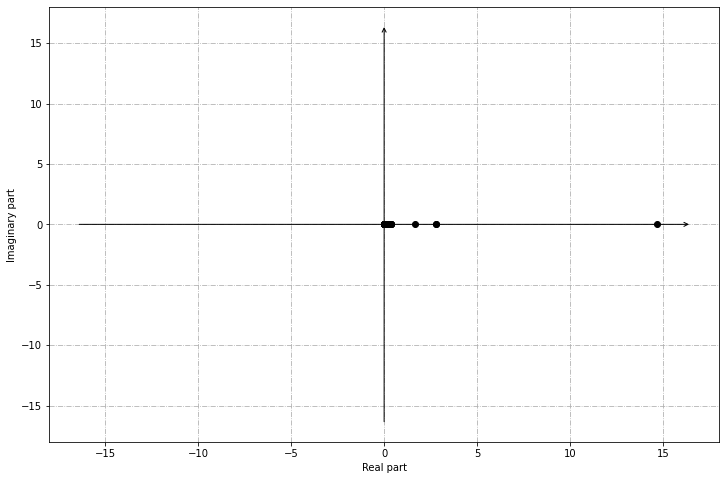

In [16]:
spod.plot_eigs()

We can then plot the **eigenvalues as a function of frequency and period** (note that we multiply the frequency by 24, that is the number of hours in a day, to obtain a period for the x-axis in days). Again, we can see how thorough the `PySPOD` object returned after the computation we can access the frequency array (`spod.freq`) along with the plotting methods `spod.plot_eigs_vs_frequency` and `spod.plot_eigs_vs_period`.

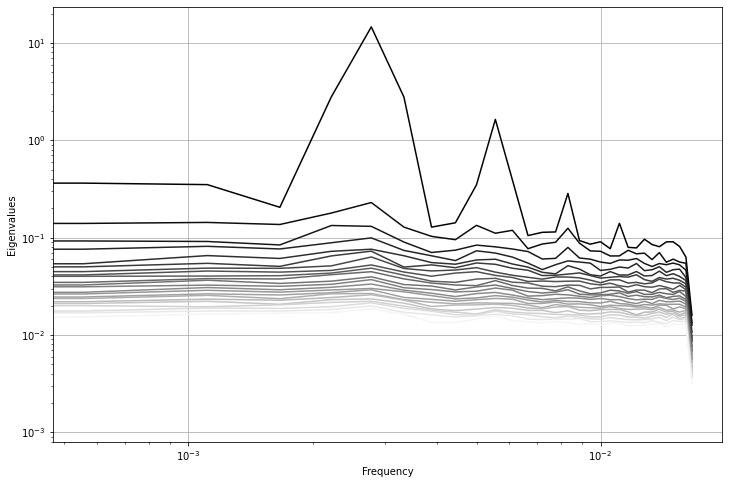

In [17]:
freq = spod.freq * 24 # (in days)
spod.plot_eigs_vs_frequency(freq=freq)

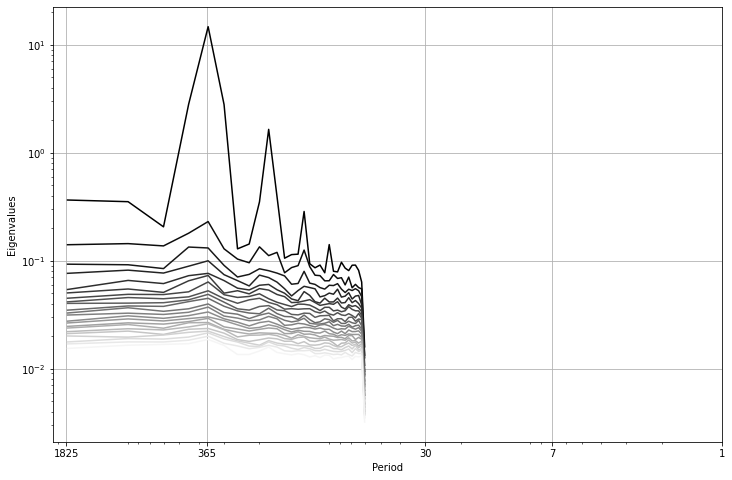

In [18]:
spod.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])

We can then plot the **modes** that were computed by the SPOD algorithm via the built-in `plot_2D_modes_at_frequency` method, that can again be accessed via the `PySPOD` object returned after the computation. To this method, we pass the frequency of the modes we are interested in. This corresponds to the frequency associated to the T_approx of 876 days that we requested, and stored in the variable `freq_found` that we calculated above. Note that we also pass the `vars_idx` corresponding to the variable we are interested in, modes_idx corresponding to the modes we are interested in, as well as `x1`, and `x2`, that correspond to longitude and latitude. We finally pass a parameter `coastlines='centred'`, that overlays a world map on top of our data. Note that we **shift longitude of 180**, as we use coastlines that goes from -180, to 180, while our data was provided from 0 to 360. 

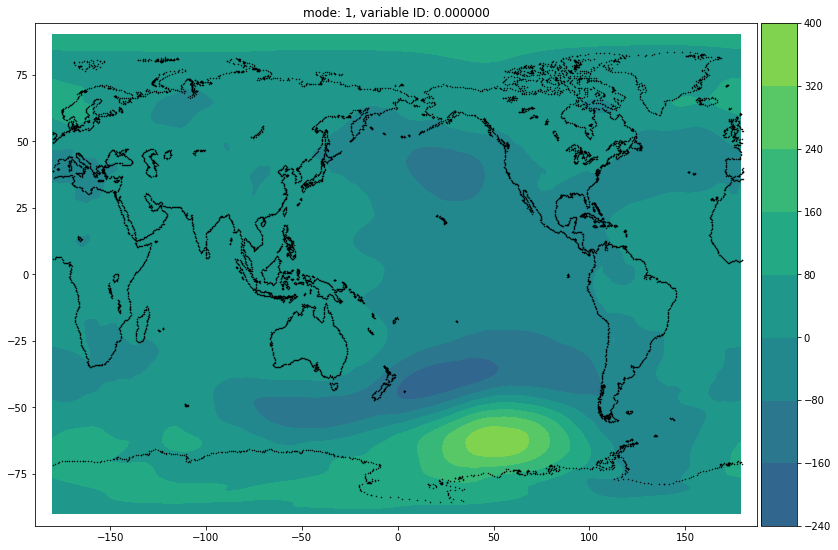

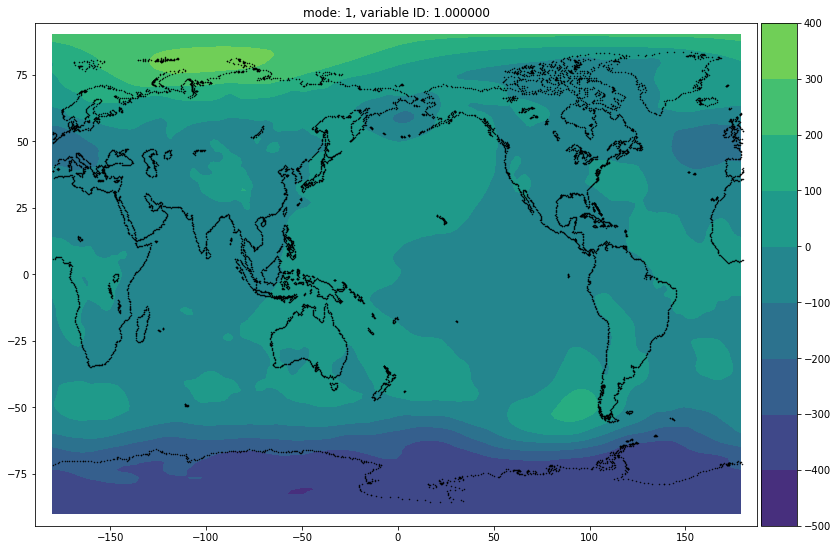

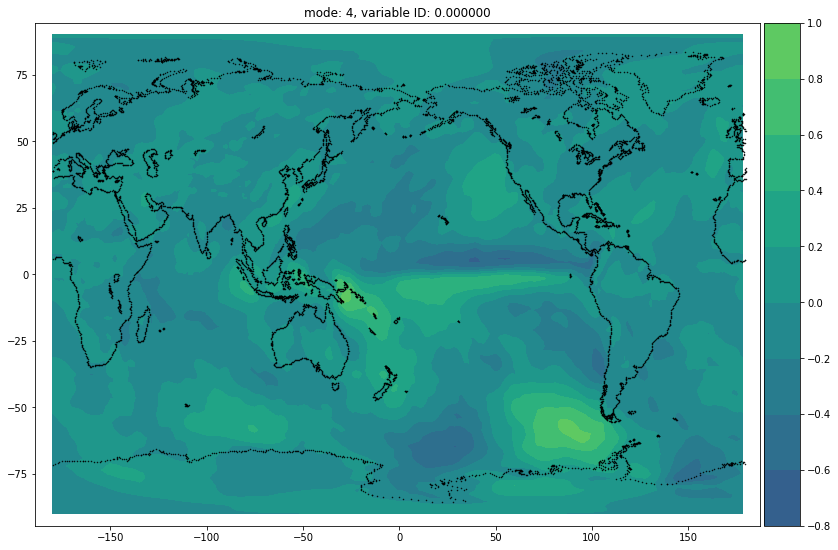

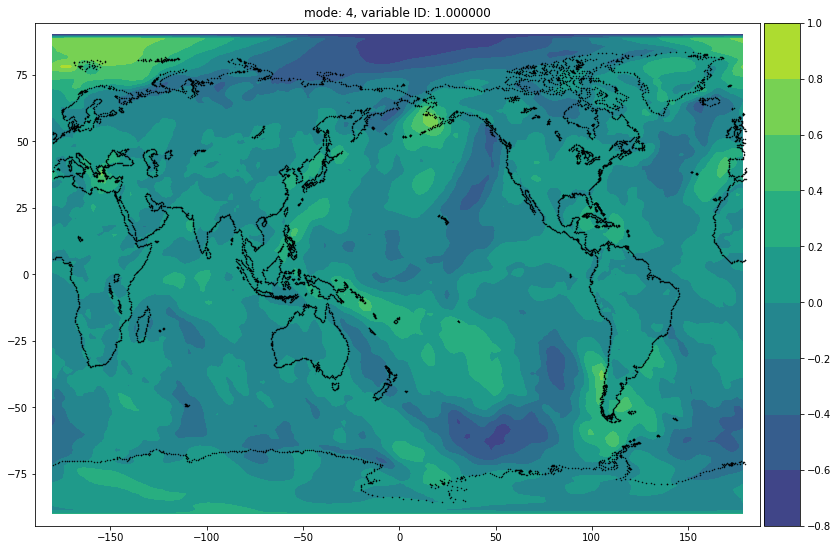

In [19]:
spod.plot_2D_modes_at_frequency(
	freq_required=freq_found, freq=freq, x1=x1-180, x2=x2, coastlines='centred', modes_idx=[0,1], vars_idx=[1,4])

Note that we can also plot the **original data** by

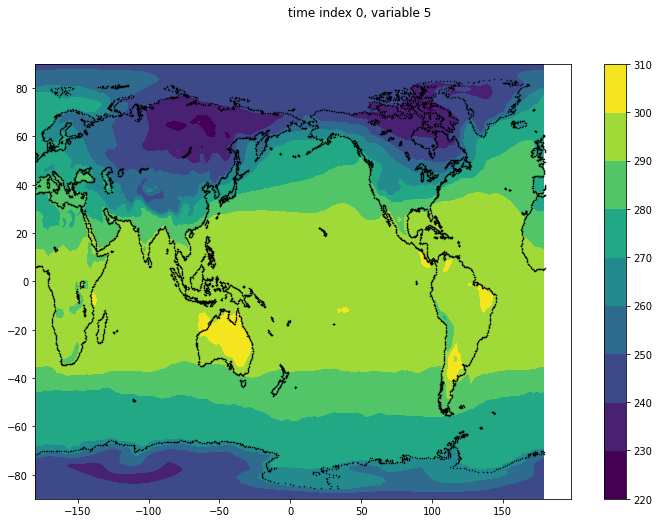

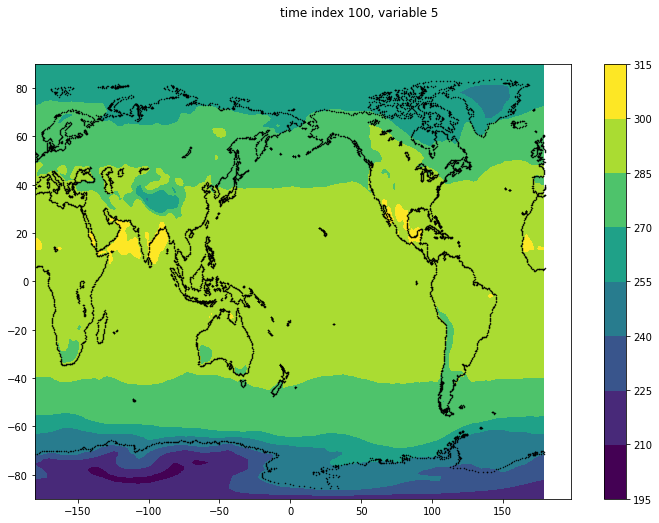

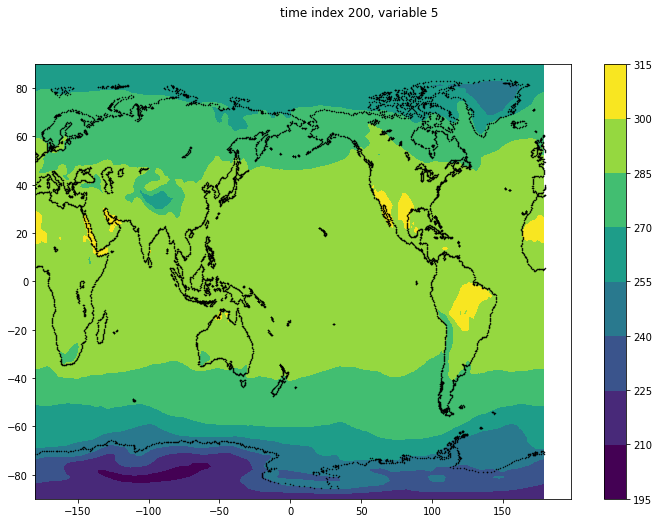

In [24]:
spod.plot_2D_data(x1=x1-180, x2=x2, coastlines='centred', vars_idx=[5], time_idx=[0,100,200])

Along with a video of the original data

In [ ]:
spod.generate_2D_data_video(x1=x1-180, x2=x2, coastlines='centred', vars_idx=[5])

IndexError: index 1332 is out of bounds for axis 0 with size 1332

## Final notes

The results are stored in the results folder defined in the parameter you specified under `params[savedir]`. We can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.

This tutorial was intended to help you setup your own multivariate case. You can play with the parameters we explored above to gain more insights into the capabilities of the library. You can also run on the same data the other two SPOD algorithms implemented as part of this library by simply calling:
- SPOD_analysis = SPOD_low_ram(X=X, params=params, file_handler=False)
- SPOD_analysis = SPOD_streaming(X=X, params=params, file_handler=False)

and compare the results.